In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import warnings

sns.set()
warnings.filterwarnings("ignore")

In [22]:
train_df = pd.read_csv('/content/drive/MyDrive/ML/Higgs Boson ML/data/training.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML/Higgs Boson ML/data/test.csv')

train_df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


### data analysis

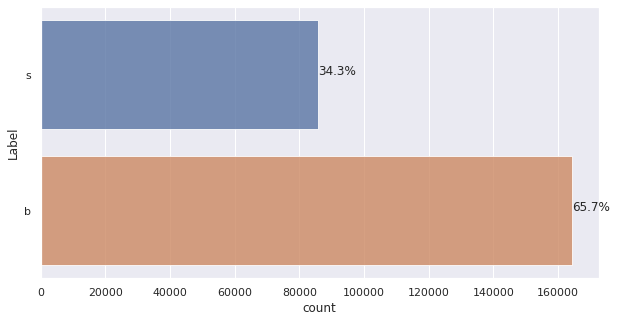

In [12]:
# посмотрим на распределение классов
plt.figure(figsize=(10,5))
ax = sns.countplot(y='Label', data=train_df, alpha=0.8)
total = train_df.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

In [13]:
train_df.dtypes

EventId                          int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_leading_eta      

In [17]:
# пропусков нет
train_df.isna().mean()

EventId                        0.0
DER_mass_MMC                   0.0
DER_mass_transverse_met_lep    0.0
DER_mass_vis                   0.0
DER_pt_h                       0.0
DER_deltaeta_jet_jet           0.0
DER_mass_jet_jet               0.0
DER_prodeta_jet_jet            0.0
DER_deltar_tau_lep             0.0
DER_pt_tot                     0.0
DER_sum_pt                     0.0
DER_pt_ratio_lep_tau           0.0
DER_met_phi_centrality         0.0
DER_lep_eta_centrality         0.0
PRI_tau_pt                     0.0
PRI_tau_eta                    0.0
PRI_tau_phi                    0.0
PRI_lep_pt                     0.0
PRI_lep_eta                    0.0
PRI_lep_phi                    0.0
PRI_met                        0.0
PRI_met_phi                    0.0
PRI_met_sumet                  0.0
PRI_jet_num                    0.0
PRI_jet_leading_pt             0.0
PRI_jet_leading_eta            0.0
PRI_jet_leading_phi            0.0
PRI_jet_subleading_pt          0.0
PRI_jet_subleading_e

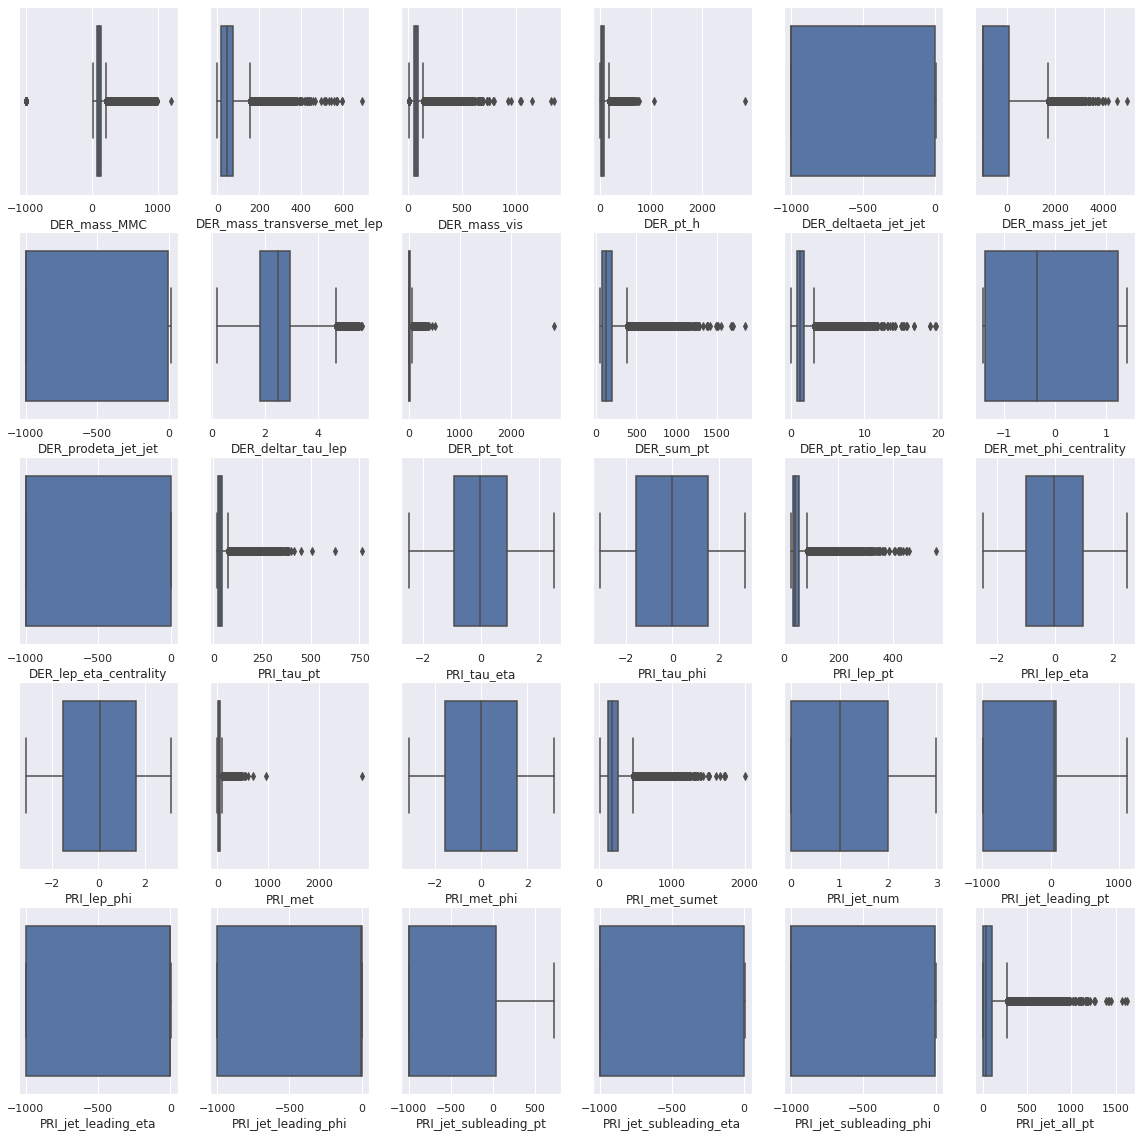

In [6]:
# есть много выбросов, но убирать их наверное не стоит
fig, axes = plt.subplots(5, 6, figsize=(20,20))
axes = axes.ravel()

for i, col in enumerate(train_df.columns[1:-2]):
    sns.boxplot(ax=axes[i], x=col, data=train_df)

### Modeling

In [23]:
enc = LabelEncoder()
train_df['Label'] = enc.fit_transform(train_df['Label'])

train_df.set_index(['EventId'], inplace=True)
test_df.set_index(['EventId'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['Label'], test_size=0.3, random_state=17)

X_train = X_train.drop(['Weight', 'Label'], axis=1)
X_test = X_test.drop(['Weight', 'Label'], axis=1)

scaler = StandardScaler()
scaler.fit(X_train.values.reshape(-1, 30))

X_train_scaled = scaler.transform(X_train.values.reshape(-1, 30))
X_test_scaled = scaler.transform(X_test.values.reshape(-1, 30))

#### LogisticRegression

In [24]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict_proba(X_test_scaled)[:, 1]

In [27]:
print('ROC-AUC:', roc_auc_score(y_test, y_pred))

ROC-AUC: 0.814608241732619


In [45]:
df_report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
df_report['ROC-AUC'] = roc_auc_score(y_test, y_pred)
df_report.index = ['LogisticRegression']

df_report

,ROC-AUC
LogisticRegression,0.814608


In [36]:
# GridSearch

lr_skf = LogisticRegression(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=17)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

clf_lr = GridSearchCV(lr_skf, param, scoring='roc_auc', refit=True, cv=skf)
clf_lr.fit(X_train_scaled, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lr.best_score_, clf_lr.best_params_))

Best roc_auc: 0.8149, with best C: {'C': 3.334, 'penalty': 'l2'}


In [37]:
# функция для возвращения таблицы с метриками

def get_scores(report_df, model, X_test, y_test, name):

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    report.index = [name]
    report_df = report_df.append(report)

    return report_df

In [46]:
df_report = get_scores(df_report, clf_lr, X_test_scaled,
                       y_test, 'LogisticRegression_skf')
df_report

,ROC-AUC
LogisticRegression,0.814608
LogisticRegression_skf,0.815319


### RandomForest

In [47]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

df_report = get_scores(df_report, rf, X_test_scaled, y_test, 'RandomForestClassifier')
df_report

,ROC-AUC
LogisticRegression,0.814608
LogisticRegression_skf,0.815319
RandomForestClassifier,0.903539


In [42]:
# GridSearch
rf_skf = RandomForestClassifier(class_weight='balanced_subsample')
skf = StratifiedShuffleSplit(n_splits=5, random_state=17)

param = {'bootstrap': [True],
         'max_depth': [10, 30],
         'n_estimators': [100, 200]}

clf_rf = GridSearchCV(
    rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose=3, n_jobs=-1)
clf_rf.fit(X_train_scaled, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_rf.best_score_, clf_rf.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 33.3min finished


Best roc_auc: 0.9052, with best C: {'bootstrap': True, 'max_depth': 30, 'n_estimators': 200}


In [48]:
df_report = get_scores(df_report, clf_rf, X_test_scaled, y_test,
                       'RandomForestClassifier_skf')
df_report

,ROC-AUC
LogisticRegression,0.814608
LogisticRegression_skf,0.815319
RandomForestClassifier,0.903539
RandomForestClassifier_skf,0.905212


### LightGBM

In [49]:
lgb = LGBMClassifier()
lgb.fit(X_train_scaled, y_train)

df_report = get_scores(df_report, lgb, X_test_scaled,
                       y_test, 'LGBMClassifier')

In [50]:
df_report

,ROC-AUC
LogisticRegression,0.814608
LogisticRegression_skf,0.815319
RandomForestClassifier,0.903539
RandomForestClassifier_skf,0.905212
LGBMClassifier,0.909294


In [51]:
# GridSearch
lgb_skf = LGBMClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=17)

param = {'learning_rate': [0.005, 0.1],
         'num_leaves': [30, 50],
         'n_estimators': [100, 200]}

clf_lgb = GridSearchCV(lgb_skf, param, scoring='roc_auc',
                       cv=skf, verbose=3, n_jobs=-1)
clf_lgb.fit(X_train_scaled, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lgb.best_score_, clf_lgb.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.8min finished


Best roc_auc: 0.911, with best C: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}


In [52]:
df_report = get_scores(df_report, clf_lgb, X_test_scaled, y_test,
                       'LGBMClassifier_skf')
df_report

,ROC-AUC
LogisticRegression,0.814608
LogisticRegression_skf,0.815319
RandomForestClassifier,0.903539
RandomForestClassifier_skf,0.905212
LGBMClassifier,0.909294
LGBMClassifier_skf,0.910649


In [54]:
lgbm_ = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=50)
rf_ = RandomForestClassifier(bootstrap=True, max_depth=30, n_estimators=200)
lr_ = LogisticRegression(C=3.334, penalty= 'l2')

clf_st = VotingClassifier(estimators=[
    ('lr', lr_), ('rf', rf_), ('lgb', lgbm_)], voting='soft')

clf_st.fit(X_train_scaled, y_train.values)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=3.334, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [55]:
df_report = get_scores(df_report, clf_st, X_test_scaled, y_test,
                       'VotingClassifier')
df_report

,ROC-AUC
LogisticRegression,0.814608
LogisticRegression_skf,0.815319
RandomForestClassifier,0.903539
RandomForestClassifier_skf,0.905212
LGBMClassifier,0.909294
LGBMClassifier_skf,0.910649
VotingClassifier,0.902728


In [56]:
# функция для посылки на kaggle
def write_to_submission(df, y_pred, out_file):
    data = df.reset_index()
    
    solution = pd.concat([data['EventId'], pd.Series(y_pred)], axis=1)
    solution.rename(columns={0: "Class"},inplace=True)
    solution = solution.replace(1,'s'); solution = solution.replace(0,'b')
    solution['RankOrder'] = solution['Class'].argsort() + 1
    solution = solution[['EventId', 'RankOrder','Class']]

    return solution.to_csv(out_file,index=False)

In [57]:
X = train_df.drop(['Weight', 'Label'], axis=1)
y = train_df['Label']

scaler = StandardScaler()
scaler.fit(X.values.reshape(-1, 30))

train_df_scaled = scaler.transform(X.values.reshape(-1, 30))
test_df_scaled = scaler.transform(test_df.values.reshape(-1, 30))

In [59]:
lgbm = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=50, n_jobs=-1)
lgbm.fit(train_df_scaled, y)

y_pred = lgbm.predict(test_df_scaled)

In [60]:
write_to_submission(test_df, y_pred, 'sub.csv') # score на kaggle - 2.87767

In [61]:
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample", n_jobs=-1).fit(train_df_scaled, y)
y_pred = rf.predict(test_df_scaled)

write_to_submission(test_df, y_pred, 'sub1.csv') # score на kaggle - 2.94268

[**Профиль на Kaggle**](https://www.kaggle.com/leoaganist)

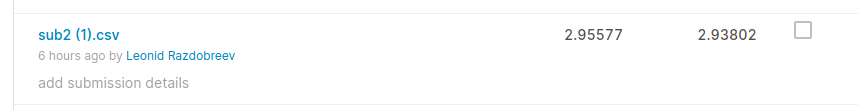

In [62]:
# Наилучший скор на kaggle
from IPython.display import Image
Image('score.png')